# Visualisation

In [36]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten,  MaxPooling2D, Conv2D, AveragePooling2D
from keras.callbacks import TensorBoard
from keras.optimizers import SGD

import visualise_filters as filtviz
import importlib
importlib.reload(filtviz)

import matplotlib.pyplot as plt
import numpy as np

import data_helper as dataset
import utils as utils
import numpy as np
import argparse as ap

from os import path
from PIL import Image
from keras import backend as K
from keras.layers import Conv2D
from keras.preprocessing.image import save_img

## Feature Maps

One simple visualisation is to visualise the feature maps generated by a convolution layer given an image.

<img src="figures/alexnet-visualise-conv-layer-1.jpeg" width="400" />






Figure illustrates 36 feature maps generated by filters in the first convolutional layer in AlexNet given a picture of a cat. The black colour indicates zero.

<img src="figures/alexnet-visualise-conv-layer-5.jpeg" width="400" />



Figure shows 64 feature maps generated by 5th convolutional layer.

## Convolutional Filters

The basic idea is to find an image which will give the highest output from a given convolutional filter. This allows us to visualise what kinds of patterns that the filter is detecting.

In [10]:
(X_train,y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000,28,28,1).astype('float32')
X_test = X_test.reshape(10000,28,28,1).astype('float32')

X_train /= 255
X_test /= 255

n_classes = 10
y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)) )
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())          
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1,
          validation_data=(X_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 3s 57us/step - loss: 0.2433 - acc: 0.9261 - val_loss: 0.0523 - val_acc: 0.9824
Epoch 2/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.0853 - acc: 0.9748 - val_loss: 0.0343 - val_acc: 0.9888
Epoch 3/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.0641 - acc: 0.9811 - val_loss: 0.0325 - val_acc: 0.9892
Epoch 4/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.0531 - acc: 0.9847 - val_loss: 0.0294 - val_acc: 0.9907
Epoch 5/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.0451 - acc: 0.9856 - val_loss: 0.0305 - val_acc: 0.9909
Epoch 6/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.0384 - acc: 0.9878 - val_loss: 0.0292 - val_acc: 0.9916
Epoch 7/15
60000/60000 [==============================] - 3s 52us/step - loss: 0.0342 - acc: 0.9888 - val_loss: 0.0275 - val_acc

### How do we visualise the filters?

- Start with a gray image with random noise as input
- Compute the gradient of the output of the filter w.r.t the input image
- Use gradient ascent to find the image pixels that maximises the output of the filter

In [101]:
def find_max_filter_image(input_tensor, output_tensor, filter_index, epochs=40, step=0.5):
    # Set up an objective function that maximises the activation of a given filter.
    # Use the average of the output feature map as our loss function.
    loss = K.mean(output_tensor[:, :, :, filter_index])

    # Compute the gradient of the objective function w.r.t the input image tensor
    grads = K.gradients(loss, input_tensor)[0]

    # Normalise the gradient of the pixels of the input image to avoids very small and very large gradients.
    # This ensures that the gradient ascent process is smooth.
    grads = grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    # Define a function that computes the loss and the gradient given an input image
    iterate = K.function([input_tensor], [loss, grads])

    # Generate a gray image with some random noise
    img_data = np.random.random((1, *image_shape)) * 20 + 128.
    
    # Gradient ascent
    for _ in range(epochs):
        loss_value, grads_value = iterate([img_data])

        # Maximise the objective function so as to activate the filter as much as possible.
        # This allows us to visualise the patterns that the filter is detecting.
        img_data += grads_value * step

        # Quit if we get stuck
        if loss_value <= K.epsilon():
            break

    return img_data, loss_value

In [102]:
def decode_image(x, image_shape):
    """
    Converts a tensor image to a valid image.
    :param x:
    :param image_shape:
    :return:
    """
    # normalize tensor: center on 0.,
    x -= x.mean()

    # Ensure std is 0.1
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to image array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    x = x.reshape(*image_shape)
    return x

In [103]:
def stitch_filters(filters, image_shape, margin=2):
    n = int(np.ceil(np.sqrt(len(filters))))

    filter_width = image_shape[0]
    filter_height = image_shape[1]
    channels = image_shape[2]

    width = n * filter_width + (n - 1) * margin
    height = n * filter_height + (n - 1) * margin
    stitched_filters = np.ones((width, height, channels), dtype='uint8') * 255

    # fill the picture with our saved filters
    for i in range(n):
        for j in range(n):
            filter_index = i * n + j
            if filter_index >= len(filters):
                break

            filter_img = filters[filter_index]
            width_margin = (filter_width + margin) * i
            height_margin = (filter_height + margin) * j
            stitched_filters[
                width_margin: width_margin + filter_width,
                height_margin: height_margin + filter_height,
                :
            ] = filter_img

    return stitched_filters

In [104]:
layer_index = 0

# Pick the convolutional layer to visualise
layer = model.layers[0]
assert isinstance(layer, Conv2D)
layer_name = layer.name
print(f'Visualising layer {layer_name}!')

image_shape = (28, 28, 1)

input_tensor = model.inputs[0] # Input image
output_tensor = layer.output   # Output feature map

processed_filters = []
for filter_index in range(layer.filters):
    img, loss_val = find_max_filter_image(input_tensor, output_tensor, filter_index)
    #print(f'  Filter {filter_index} achieved loss value: {loss_val}')
    processed_filters.append(decode_image(img, image_shape))

stiched_filters = stitch_filters(processed_filters, image_shape)

Visualising layer conv2d_7!


In [105]:
im = stiched_filters.reshape(stiched_filters.shape[0], stiched_filters.shape[1])

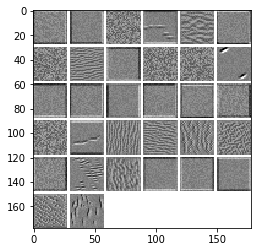

In [106]:
plt.imshow(im, cmap='gray')

More on filter visualisations: http://yosinski.com/deepvis

## 